In [14]:
# --- about
# this file starts with notebook 'bootstrap' and does the following:
# - download bootstrap results to a file
# - compute confidence interval on development set bootstrap accuracy
# - compute test accuracy on test set

# notebooks left to do:

# add qa step to test bootstrap on normal distribution alongside spectra data
# testing algorithms on pure spectra only, no mixtures
# kfold
# do multiple runs and record mean and variance of results

In [15]:
# --- set up environment

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as art
from sklearn.decomposition import FastICA
import bootstrapped.bootstrap as bs

# for Set working folder, etc.
import os
import os.path

# for sampling 
import random

# test code
# print(os.getcwd())

In [16]:
# --- etl spectrum files

# turn files into lists and cut off first line
# put into database "spectra"
# turn deleted points (flagged as -1.23e+34) into 0's
# label spectra with datafile titles


# - init spectra and class databases
datafolder = "C:/Users/Bonita/Documents/GitHub/spectra-ml/data/dataset3"
num_samples = len([name for name in os.listdir(datafolder) if \
                   os.path.isfile(os.path.join(datafolder,name))])
# test code 
# print(num_samples)

spectrum_len = 480                                 # 480 >= the BECK spectrometer spectrum length
spectra = np.zeros((num_samples,spectrum_len))
spectrum_categories = np.zeros(num_samples)
first_record_of_mixtures_chapter = 11602
is_a_mineral = 1                                   # these numbers match the chapter numbers given by usgs
is_a_mixture = 2
spectrum_names = ["" for x in range(num_samples)]

y = np.zeros((num_samples, 1))


# - fill databases
i = 0

# find spectra folder
os.chdir(datafolder)

# - etl the data
# - create a spectrum_names string matrix for populating the plot legends
# - find record number for identifying mixtures, which will be plotted in thicker lines
for filename in os.listdir(datafolder):
    
    # read file
    file_object  = open(filename, 'r').readlines()
    # strip off header, add to matrix 'spectra'
    spectra[i,:] = file_object[1:]                  
    
    # find file header
    file_header = file_object[0]             
                                        
    # make spectrum_names matrix to label spectra in the plot legends
    spectrum_names[i] = file_header
    
    # categorize spectrum as mineral or mixture:
    # find record number in the header 
    # change from string to integer
    # use it to identify and label minerals versus mixtures
    # (minerals are records <=first_record_of_mixtures_chapter)
    # (see report pg 3 from https://pubs.er.usgs.gov/publication/ds1035 
    # ...for list of categories, 'chapters')
    # (*will need to update if we want to use and categorize spectra from other categories)
    # store category in spectra_category
    ####
    start = 'Record='
    end = ':'
    record_number = int((file_header.split(start))[1].split(end)[0])
    # print(record_number)
    if record_number < first_record_of_mixtures_chapter:
        spectrum_categories[i] = is_a_mineral
    else:
        spectrum_categories[i] = is_a_mixture
        
    # testcode
    # print('record_number: ', record_number)
    
    # testcode
    # print(spectrum_categories)
    
    # testcode
    # print(file_header)
    
    # label spectrum class, based on header
    # actinolite: 0, alunite: 1, chlorite: 2
    if file_header.find('Actinolite',)!= -1: #if material name contains actinolite
        y[i,0] = 0
    elif file_header.find('Alun',)!= -1:
        y[i,0] = 1
    else:                                       #chlorite
        y[i,0] = 2         
               
    # turn deleted points into 0
    for j in range(spectrum_len):  
        if spectra[i,j] <0:
            spectra[i,j]=0                          
    i+=1

# test code
# print(y[:])
# print(spectra[0:2,0])

In [17]:
# --- etl 

# divide up data randomly into train, dev and test populations

# 60% training set, 20% validation set, 20% test set 
sample_indices = list(range(0, num_samples))
random.shuffle(sample_indices)
train_population_size = 3*(num_samples//5)
dev_population_size = (num_samples//5)
test_population_size= num_samples-dev_population_size - train_population_size
train_population_indices = sample_indices[0:train_population_size]
dev_population_indices = sample_indices[train_population_size: train_population_size+dev_population_size]
test_population_indices= sample_indices[train_population_size+dev_population_size: num_samples]

#testcode
print(len(train_population_indices)==train_population_size)
print(len(dev_population_indices)==dev_population_size)
#print(test_population_indices)

#testcode
#print(type(np.setdiff1d(sample_indices,train_set_indices)))
      
#dev_set_indices = random.sample(np.setdiff1d(sample_indices,train_set_indices), dev_set_size) #sample remaining spectra

    

# test code
# print(train_set_size)
# print(dev_set_size)
# print(test_set_size)

# test code
# print(train_set_indices)
# print(test_set_indices)

True
True


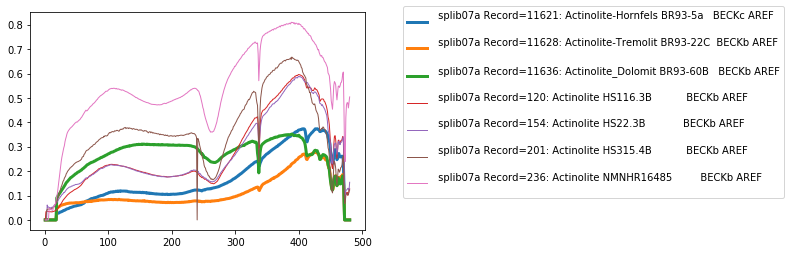

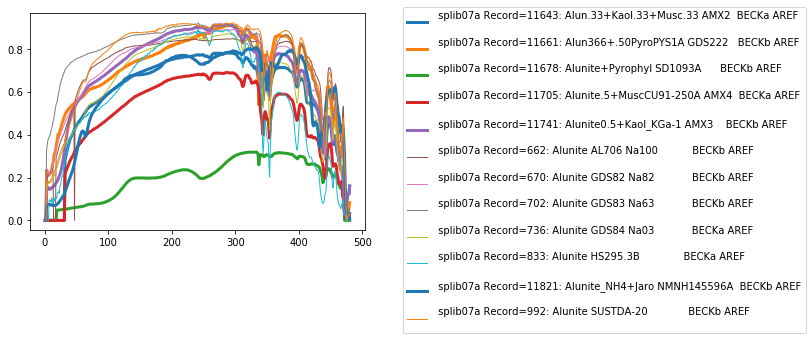

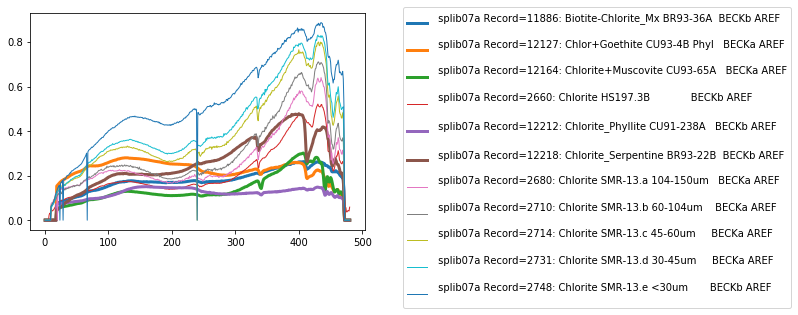

In [18]:
# --- plot the classes

# plot each class in a separate plot
# plot spectra names in legend
# plot minerals and mixtures w diff line widths

# variables
num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

mineral_linewidth = 1         # linewidth = 1 is default
mixture_linewidth = 3         

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

labels0 = ["" for x in range(num0)]
labels1 = ["" for x in range(num1)]
labels2 = ["" for x in range(num2)]

linewidth0 = np.zeros(num0)
linewidth1 = np.zeros(num1)
linewidth2 = np.zeros(num2)


# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# set linewidth for the spectrum 
# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    
    # set linewidth
    #testcode
    #print(spectrum_categories)
    #print(spectrum_categories[i])
    
    if spectrum_categories[i] == is_a_mineral:
        linewidth = mineral_linewidth
        
        #testcode
        #print('min')
    else: 
        linewidth = mixture_linewidth
        
        #testcode
        #print('mix')
    
    # populate matrices for making each class plot
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        labels0[i0] = spectrum_names[i]
        linewidth0[i0] = linewidth
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        labels1[i1] = spectrum_names[i]
        linewidth1[i1] = linewidth
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        labels2[i2] = spectrum_names[i]
        linewidth2[i2] = linewidth
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(range(1, spectrum_len+1), spectra0[i,:], label = labels0[i], linewidth = linewidth0[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i1):
    plt.plot(range(1, spectrum_len+1), spectra1[i,:], label = labels1[i], linewidth = linewidth1[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i2):
    plt.plot(range(1, spectrum_len+1), spectra2[i,:], label = labels2[i], linewidth = linewidth2[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()  

In [19]:
# --- test model 

# test once each on dev and test set
# model will be trained on the whole train population
# (test cell comes before bootstrap cell bc bootstrap takes much longer)

# make train, dev and test sets
train_set = spectra[train_population_indices, :]
train_set_labels = y[train_population_indices, :]
dev_set = spectra[dev_population_indices, :]
dev_set_labels = y[dev_population_indices,:]
test_set = spectra[test_population_indices, :]
test_set_labels = y[test_population_indices, :]

# train, validate and test model
num_epochs = 15

model = keras.Sequential([
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# train
History = model.fit(train_set, train_set_labels, epochs=num_epochs)

epoch_accs = History.history['acc']
train_acc = epoch_accs[num_epochs-1]   #record final epoch, plain nn train result, acc[...]), for each run

# test on dev set
dev_loss, dev_acc = model.evaluate(dev_set, dev_set_labels)

# test on test set
test_loss, test_acc = model.evaluate(test_set, test_set_labels)
    
# see and save results
print(train_acc, dev_acc, test_acc)


Epoch 1/15
18/18 [==============================] - 0s 23ms/step - loss: 1.1651 - acc: 0.4444
Epoch 2/15
18/18 [==============================] - 0s 0us/step - loss: 0.9456 - acc: 0.3889
Epoch 3/15
18/18 [==============================] - 0s 868us/step - loss: 0.8680 - acc: 0.6667
Epoch 4/15
18/18 [==============================] - 0s 869us/step - loss: 0.7612 - acc: 0.6667
Epoch 5/15
18/18 [==============================] - 0s 0us/step - loss: 0.6783 - acc: 0.6667
Epoch 6/15
18/18 [==============================] - 0s 0us/step - loss: 0.6525 - acc: 0.7778
Epoch 7/15
18/18 [==============================] - 0s 868us/step - loss: 0.6397 - acc: 0.7222
Epoch 8/15
18/18 [==============================] - 0s 0us/step - loss: 0.6015 - acc: 0.7222
Epoch 9/15
18/18 [==============================] - 0s 0us/step - loss: 0.5627 - acc: 0.7222
Epoch 10/15
18/18 [==============================] - 0s 868us/step - loss: 0.5435 - acc: 0.6667
Epoch 11/15
18/18 [==============================] - 0s 0us/

In [ ]:
# --- bootstrap variables

num_bootstrap_runs = 100

train_set_size = train_population_size
dev_set_size = dev_population_size
test_set_size = test_population_size

num_model_types = 1                                 #plain nn (this is here because originally two models, nn and ica)
num_tests_per_model = 2                             #train and dev accuracy 
num_tests = num_model_types*num_tests_per_model
num_metrics_per_test = 2                                  #accuracy mean and var

bresults = np.zeros((num_tests, num_bootstrap_runs))

itrainnn = 0        #index in bresults of the train nn results
idevnn = 1

In [ ]:
# --- bootstrap loop

# -select bootstrap sets
# -run algorithm
# -repeat num_bootstrap_runs times
# -collect mean and variance of nn train, nn dev, ica train, ica test accuracies and store in bstatsfor run in range(num_bootstrap_runs):

for run in range(num_bootstrap_runs):
    # - bootstrap sample the populations to make sets
    # make train, dev, and test sets from their respective populations

    #  draw with replacement from the populations
    train_set_indices = random.choices(train_population_indices, k=train_set_size)
    dev_set_indices = random.choices(dev_population_indices, k=dev_set_size)
    test_set_indices = random.choices(test_population_indices, k=test_set_size)

    # make train and test sets
    train_set = spectra[train_set_indices, :]
    train_set_labels = y[train_set_indices, :]
    dev_set = spectra[dev_set_indices, :]
    dev_set_labels = y[dev_set_indices,:]
    test_set = spectra[test_set_indices, :]
    test_set_labels = y[test_set_indices, :]    
    
    # - set up model
    # model is re-declared here to decouple the model from the test cell
    # model is in general supposed to be the same model as in the test cell
    # but for simplicity i re-declare it in case we want to change it for any reason
    num_epochs = 15

    model = keras.Sequential([
        keras.layers.Dense(300, activation=tf.nn.relu),
        keras.layers.Dense(100, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])

    # compile
    model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    # train
    History = model.fit(train_set, train_set_labels, epochs=num_epochs)

    acc = History.history['acc']
    bresults[itrainnn, run] = acc[num_epochs-1]   #record final epoch, plain nn train result, acc[...]), for each run
    
    #testcode
    #print(bruns)    # --- test plain nn on dev set

    # test on dev set
    dev_loss, dev_acc = model.evaluate(dev_set, dev_set_labels)

    bresults[idevnn,run] = dev_acc
    

    
   

In [ ]:
# --- bootstrap stats
print(run)
print(bresults)

num_stats = 2           #mean and var
bstats = np.zeros((num_stats, num_tests))
imean = 0               #row index of means
ivar = 1

nonemptyresults = bresults[:,:run]

for test in range(num_tests):
    bstats[imean,test] = np.mean(nonemptyresults[test,:])    
    bstats[ivar,test] = np.var(nonemptyresults[test,:])

print(bstats)



In [ ]:
# --- calculate bootstrap confidence interval

In [ ]:
# --- kfold cross validation